## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, roc_auc_score, roc_curve

## Load dataset

In [2]:
salary_df = pd.read_csv('SalaryData_Train.csv')

In [3]:
salary_df.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Initial analysis

In [4]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null  object
 3   educationno    30161 non-null  int64 
 4   maritalstatus  30161 non-null  object
 5   occupation     30161 non-null  object
 6   relationship   30161 non-null  object
 7   race           30161 non-null  object
 8   sex            30161 non-null  object
 9   capitalgain    30161 non-null  int64 
 10  capitalloss    30161 non-null  int64 
 11  hoursperweek   30161 non-null  int64 
 12  native         30161 non-null  object
 13  Salary         30161 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


In [5]:
salary_df['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

In [6]:
salary_df['education'].unique()# ordinal

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th'], dtype=object)

In [7]:
salary_df['educationno'].unique()

array([13,  9,  7, 14,  5, 10, 12,  4, 16, 11, 15,  3,  6,  1,  8,  2],
      dtype=int64)

In [8]:
salary_df['maritalstatus'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [9]:
salary_df['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving',
       ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
       ' Craft-repair', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [10]:
salary_df['relationship'].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [11]:
salary_df['race'].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [12]:
salary_df['sex'].unique()

array([' Male', ' Female'], dtype=object)

In [13]:
salary_df['native'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary'], dtype=object)

Salary <= 50K: 22653 
Salary  > 50K : 7508


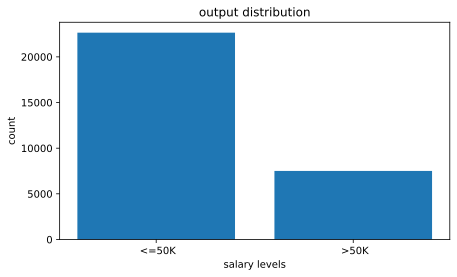

In [14]:
sal_levels = salary_df['Salary'].unique()
below_50 = salary_df['Salary'][salary_df['Salary']== ' <=50K'].count()
above_50 = salary_df['Salary'][salary_df['Salary']== ' >50K'].count()
salaries = dict.fromkeys(sal_levels)
salaries[' <=50K'] = below_50
salaries[' >50K'] = above_50
print("Salary <= 50K: {} \nSalary  > 50K : {}".format(below_50, above_50))

fig, ax = plt.subplots()
ax.bar(salaries.keys(), salaries.values())
ax.set_xlabel('salary levels')
ax.set_ylabel('count')
ax.set_title('output distribution')
plt.show()

### Observations:
- 3061 records 13 features and one target.
- All columns entered with correct datatypes.
- No null values.
- Imbalanced dataset. If the predictions are used to spot people who show lower income than their actual, then it becomes important to correctly predict the people who would be earning more than 50K.
- We are likely to make good predictions for people who get salary below 50K since we have more number of observations for this group.
- Naming convention to be used for output class:
    - salary <= 50K --> 0
    - salary > 50K --> 1

## Data preprocessing

In [15]:
# Extracting column names and sorting them to appropriate categories.
def column_segregator(df, y_name=None):
    """ Returns  three lists of column headers for feature columns, 
    numeric columns and categorical columns
    Input
    ------
    df: Dataframe
    y_name: default None. Name(str) of target column if available
    
    Output
    ------
    features, numeric_cols, cat_cols"""   
    
    cols = df.columns # List of all columns in the input dataframe.
    numeric_cols = [col for col in cols if (df[col].dtypes != 'object') and col != y_name]
    cat_cols = [col for col in cols if (df[col].dtypes == 'object') and col != y_name]
    features = [col for col in cols if col != y_name]
    
    return features, numeric_cols, cat_cols 

In [16]:
def Xy_split(df, y_name=None, y_col=True):
    """Splits the input dataframe into features and target
    input
    -----
    df: Input dataframe
    y_name: default None. Name(str) of target column if available
    y_col: 'True' if y column is present in input dataframe, else 'False'.
    
    output
    ------
    X (features) , y (target) if y colum is present else only X"""
    
    target = y_name
    feature_col,_,_ = column_segregator(df, target)
    if y_col == True:
        # separating features and target.
        X = df.loc[:, feature_col]
        y = df.loc[:, target]
        return X,y
    else:
        X = df.loc[:, feature_col]
        return X

In [17]:
# Get the list of column names to aid in data filtering:
feature_col, num_col, cat_col = column_segregator(salary_df, y_name='Salary')

In [18]:
# Split features and target.
X, y = Xy_split(salary_df, y_name='Salary', y_col=True)

### Train test split and encoding

In [19]:
# Train test split.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Encoding

# output labbels
le = LabelEncoder() 
le.fit(y_train)
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

# input categorical data
enc = OrdinalEncoder() #input
inp_encoder = enc.fit(X_train.loc[:, cat_col])

def train_encode(inp_encoder, X_train, cat_col):
    """Function to encode the categorical features and target in the input training df
    input
    ------
    inp_encoder: encoder object for input cat features(to be defined before; ordinal encoder) 
    out_encoder: encoder object for target labels(to be defined before; label encoder) 
    X_train: Dataframe
    cat_col: list of categorical columns (list)
    
    output
    ------
    X_train (encoded)"""
    
    X_train_enc = pd.DataFrame(inp_encoder.transform(X_train.loc[:, cat_col]),
                              index=X_train.index, columns=X_train.loc[:, cat_col].columns)
    # Dropping original categorical columns
    X_train = X_train.drop(cat_col, axis=1)
    # Concatenating the encoded columns:
    X_train = pd.concat([X_train, X_train_enc], axis=1)
    
    return X_train

def validation_encode(inp_encoder, X_valid, cat_col):
    """Function to encode the categorical features and target in the input validation/test df
    input
    ------
    inp_encoder: "pre fit" encoder object for input cat features(to be defined before; ordinal encoder) 
    X_valid: Validation data frame
    cat_col: list of categorical columns (list)
    
    output
    ------
    X_valid (encoded) """
    
    X_valid_enc = pd.DataFrame(inp_encoder.transform(X_valid.loc[:, cat_col]),
                               index=X_valid.index, columns=X_valid.loc[:, cat_col].columns)
    # Dropping original categorical columns
    X_valid = X_valid.drop(cat_col, axis=1)
    # Concatenating the encoded columns:
    X_valid = pd.concat([X_valid, X_valid_enc], axis=1)
    
    return X_valid


In [21]:
X_train = train_encode(inp_encoder, X_train, cat_col)

In [22]:
X_valid = validation_encode(inp_encoder, X_valid, cat_col)

### Output distribution of train and test data - verification

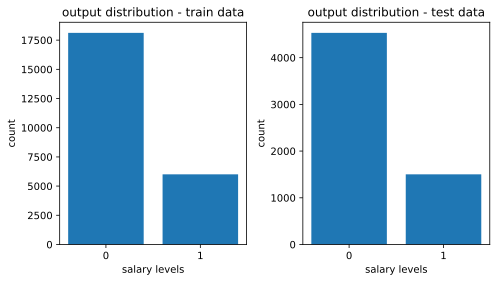

In [23]:
# Segregating target into zero and 1 class for bar chart
# to examine target distribution in split data.
y_train_0 = len([val for val in y_train if val == 0])
y_train_1 = len([val for val in y_train if val == 1])
y_valid_0 = len([val for val in y_valid if val == 0])
y_valid_1 = len([val for val in y_valid if val == 1])

# Bar chart to verify if the train test split correctly captured the 
# output distribution.
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].bar(['0', '1'], [y_train_0, y_train_1])
ax[0].set_xlabel('salary levels')
ax[0].set_ylabel('count')
ax[0].set_title('output distribution - train data')

ax[1].bar(['0', '1'], [y_valid_0, y_valid_1])
ax[1].set_xlabel('salary levels')
ax[1].set_ylabel('count')
ax[1].set_title('output distribution - test data')

fig.tight_layout()
plt.show()

## Model building

## Naive bayes algorithm

### Constructing a Naive bayes classifier froms scratch
**Note:** This classifier will be referred to as **simple Naive Bayes classifier** for the remainder of this notebook. 

Ref: https://towardsdatascience.com/implementing-naive-bayes-in-2-minutes-with-python-3ecd788803fe

**PS:** I tried this just to get an understanding of how to roughly construct a fit and predict function. I have used a gaussian naive bias after this for predictions on the final test data set provided.

### Naive Bayes fit function:

In [24]:
# Naive bayes classifier function:
def NaiveBayesClassifier_fit(X_train, y_train):
    """Returns a tuple containing mean, standard deviation and 
    probability for each output class of the input data
    Input
    -----
    X_train, y_train: Dataframes
    
    Output
    ------
    means, stds, probs"""
    
    # Statistics for the train set
    means = X_train.groupby(y_train).apply(np.mean)
    stds = X_train.groupby(y_train).apply(np.std)

    # Class prior probabilities
    probs = X_train.groupby(y_train).apply(lambda x: len(x)/X_train.shape[0])
    return (means, stds, probs)


### Naive Bayes predict function:


In [25]:
def NaiveBayesClassifier_predict(nb_fit, X_valid):
    """Returns an array containing the predicted labels for
    input data frame (test data)
    
    Input
    -----
    means, stds, probs, X_valid: from NaiveBayesClassifier_fit(X_train, y_train)
    
    Output
    ------
    y_pred: predicted output class labels (0 or 1) """
    
    means, stds, probs = nb_fit
    # predict function.
    y_pred = []
    
    # for each element in the test set
    for elt in range(X_valid.shape[0]):
        p = {}

        # for each possible class
        class_labels = probs.index
        for cl in class_labels:

            #take prior probability of the given class
            p[cl] = probs.iloc[cl]

            # for each column in the data
            for index, param in enumerate(X_valid.iloc[elt]):

                # multiply by the probability of the given column value to belong to the distribution
                # of the train column for the given class
                p[cl] *= stats.norm.pdf(param, means.iloc[cl, index], stds.iloc[cl, index])
        y_pred.append(pd.Series(p).values.argmax())
    return y_pred
#Note: this algorithm is very slow compared to gaussian NB from sklearn

In [26]:
nb_fit = NaiveBayesClassifier_fit(X_train, y_train)

In [27]:
y_pred = NaiveBayesClassifier_predict(nb_fit, X_valid)

## Model predictions

### Predictions and evaluation for train data - simple Naive Bayes classifier

In [28]:
def display_results(y_test, y_pred):
    """Displays model evaluation/performance report that includes
    accuracy_score, confusion_matrix, precision_score, and 
    recall_score.
    input
    -----
    y_test, y_pred
    
    output
    ------
    Model evaluation/performance report"""
    
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    

In [29]:
display_results(y_valid, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.95      0.88      4531
           1       0.71      0.33      0.45      1502

    accuracy                           0.80      6033
   macro avg       0.76      0.64      0.66      6033
weighted avg       0.79      0.80      0.77      6033

Confusion matrix:
 [[4327  204]
 [1008  494]]


### Comparing the accuracy of the predicitons with GaussianNB from sklearn.

In [30]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [31]:
y_pred_gnb = gnb.predict(X_valid)

In [32]:
display_results(y_valid, y_pred_gnb)

              precision    recall  f1-score   support

           0       0.81      0.95      0.88      4531
           1       0.70      0.32      0.43      1502

    accuracy                           0.80      6033
   macro avg       0.75      0.64      0.66      6033
weighted avg       0.78      0.80      0.77      6033

Confusion matrix:
 [[4324  207]
 [1027  475]]


## Running the model on test dataset

In [33]:
salary_tdf = pd.read_csv('SalaryData_Test.csv')

In [34]:
salary_tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            15060 non-null  int64 
 1   workclass      15060 non-null  object
 2   education      15060 non-null  object
 3   educationno    15060 non-null  int64 
 4   maritalstatus  15060 non-null  object
 5   occupation     15060 non-null  object
 6   relationship   15060 non-null  object
 7   race           15060 non-null  object
 8   sex            15060 non-null  object
 9   capitalgain    15060 non-null  int64 
 10  capitalloss    15060 non-null  int64 
 11  hoursperweek   15060 non-null  int64 
 12  native         15060 non-null  object
 13  Salary         15060 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.6+ MB


In [35]:
salary_tdf.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


Salary <= 50K: 11360 
Salary  > 50K : 3700


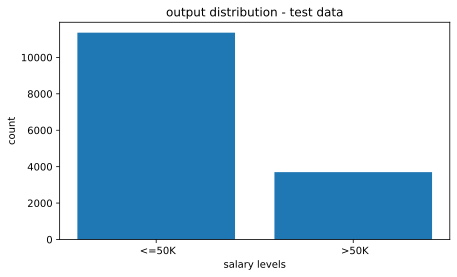

In [36]:
sal_levels_t = salary_tdf['Salary'].unique()
below_50_t = salary_tdf['Salary'][salary_tdf['Salary']== ' <=50K'].count()
above_50_t = salary_tdf['Salary'][salary_tdf['Salary']== ' >50K'].count()
salaries_t = dict.fromkeys(sal_levels_t)
salaries_t[' <=50K'] = below_50_t
salaries_t[' >50K'] = above_50_t
print("Salary <= 50K: {} \nSalary  > 50K : {}".format(below_50_t, above_50_t))

fig, ax = plt.subplots()
ax.bar(salaries_t.keys(), salaries_t.values())
ax.set_xlabel('salary levels')
ax.set_ylabel('count')
ax.set_title('output distribution - test data')
plt.show()

In [37]:
# Split features and target.
X_test, y_test = Xy_split(salary_tdf, y_name='Salary', y_col=True)

In [38]:
# Encoding test data.

# output labels
y_test = le.transform(y_test)

# input labels
X_test = validation_encode(inp_encoder, X_test, cat_col) 

In [39]:
# Predictions from simple naive bayes classifier constructed above
y_pred_test = NaiveBayesClassifier_predict(nb_fit, X_test)

In [40]:
# Results for predictions from simple naive bayes classifier constructed above. 
display_results(y_test, y_pred_test)

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     11360
           1       0.68      0.33      0.44      3700

    accuracy                           0.80     15060
   macro avg       0.74      0.64      0.66     15060
weighted avg       0.78      0.80      0.77     15060

Confusion matrix:
 [[10777   583]
 [ 2480  1220]]


In [41]:
# Predictions from gaussian naive bayes classifier constructed above.
y_pred_test_gnb = gnb.predict(X_test)

In [42]:
# Results for predictions from gaussian naive bayes classifier constructed above. 
display_results(y_test, y_pred_test_gnb)

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     11360
           1       0.67      0.32      0.43      3700

    accuracy                           0.79     15060
   macro avg       0.74      0.64      0.65     15060
weighted avg       0.78      0.79      0.77     15060

Confusion matrix:
 [[10771   589]
 [ 2509  1191]]


## Observations:
- As can be seen from the reports above, despite the accuracy being 0.79 or 79% for training set and 80% for the test set, the model is poorly classsifying the 1 class (salary > 50K). 
- There are a lot of false negatives (2509). This may not be good since the model is wrongly classifying people with salary >50K as below 50K. We would tend to miss out the people with higer incomes and this is not good if the problem statement is to correctly find out people who are earning very high salaries. There are very high chances for this scenario, since there is a huge difference between precison and recall scores for the 1 class.
- Incorrectly classifying people with salary <= 50K (0 class) as otherwise (1 class) is also not good since they may unnecesarily come under scrutiny (if the analysis is being performed by government).


## Conclusion:
- A naive bayes (implemented from scratch) and gaussian naive bayes algorithms were used to classify salary data. The performance of both the models is not very good since there are a significant number of false positives